In [ ]:
!pip install wordcloud
!pip install gensim
!pip install -U sentence-transformers

# Step 1: Sentences Modeling

In [2]:
# MODEL = 'bert-base-cased'
# MODEL = 'dmis-lab/biobert-base-cased-v1.1'
# MODEL = 'bert-sts'
# MODEL = 'fagner/envoy'
MODEL = 'biobert-nli'

In [3]:
import os.path
import pandas as pd
from sentence_transformers import SentenceTransformer

DATASET = 'clicr'
DATASET_PATH = '../datasets/'+DATASET+'/cases-titles.txt'

sentences = []
with open(DATASET_PATH) as f:
    sentences = f.readlines()

OUTPUT_PATH = 'output/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += DATASET + '/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += MODEL + '/'
if not os.path.exists(OUTPUT_PATH): os.makedirs(OUTPUT_PATH, exist_ok=True)

In [4]:
# model = SentenceTransformer(MODEL)
# embeddings = model.encode(sentences)

MODEL_PATH = '../../models/' + MODEL
model = SentenceTransformer(MODEL_PATH)
embeddings = model.encode(sentences)

<Figure size 640x480 with 0 Axes>

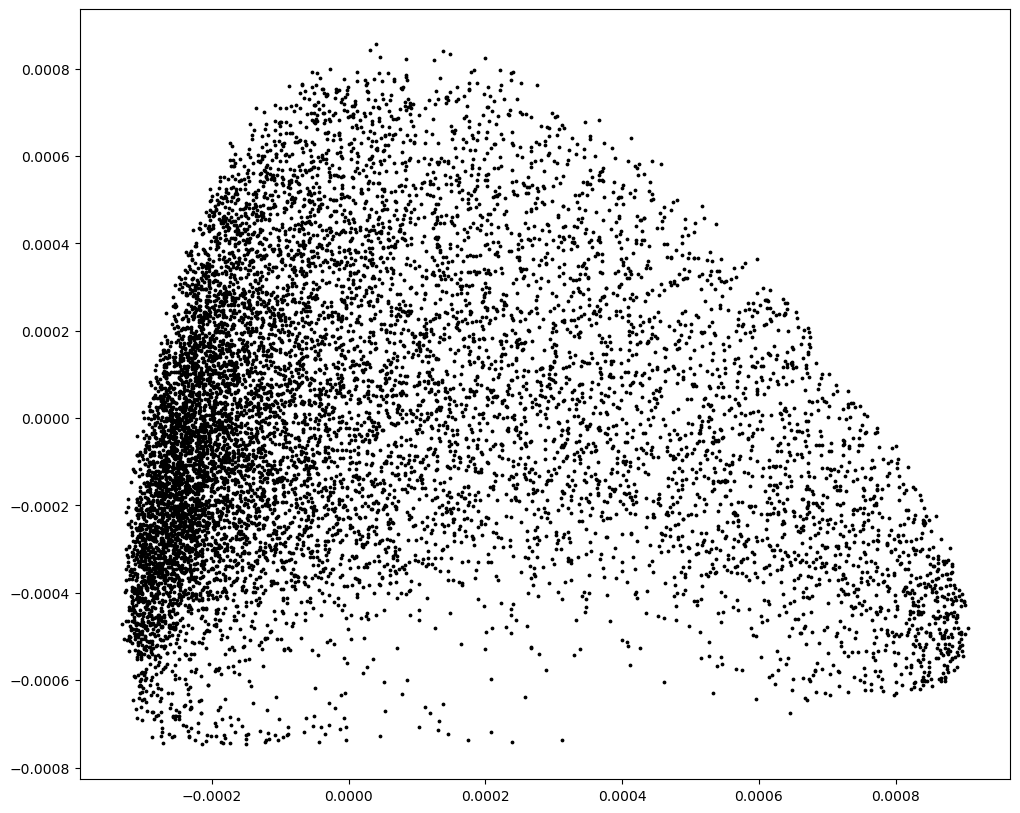

In [5]:
from matplotlib import pyplot as plt 
from sklearn import manifold

X_2d = manifold.SpectralEmbedding(n_components=2).fit_transform(embeddings)
 
x = X_2d[:,0]
y = X_2d[:,1]

plt.clf()
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black', s=3)
plt.savefig(OUTPUT_PATH + 'sentence-embeddings-'+str(MODEL).replace('/','').replace('.','') + '.jpg', bbox_inches='tight')
# plt.savefig(OUTPUT_PATH + 'sentence-embeddings-'+str(MODEL).replace('/','').replace('.','') + '.eps', bbox_inches='tight', format='eps')

# Step 2: Sentences Aggregation

In [6]:
# DISTANCE_THRESHOLD = 10.5 # 100 80 62 60 55 48 44 40.25 40 17.85 15.5 13.79 11.83  10.5    bert-base-cased
# DISTANCE_THRESHOLD =  11.8  # 90 77 60 55 52.7 52  51.6 51 50 47 40 21.7 15.7 13.4537 biobert
DISTANCE_THRESHOLD =   200 # 300 250 200 190 150 130 125 120 biobert-nli
# DISTANCE_THRESHOLD =   300  #  300 250 175 150 145 142 140 130 120 96 95.6 20 sts-bert
# DISTANCE_THRESHOLD =   150 # 500 400 300 220 180 156.5 150 130 120 110 36.5 envoy

In [7]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(linkage='ward', distance_threshold=DISTANCE_THRESHOLD, n_clusters=None)
clustering_model = clustering_model.fit(embeddings)

n_clusters = clustering_model.n_clusters_

print('Distance Threshold: ', DISTANCE_THRESHOLD)
print('Resulting Clusters:',  n_clusters)

Distance Threshold:  200
Resulting Clusters: 3


<Figure size 640x480 with 0 Axes>

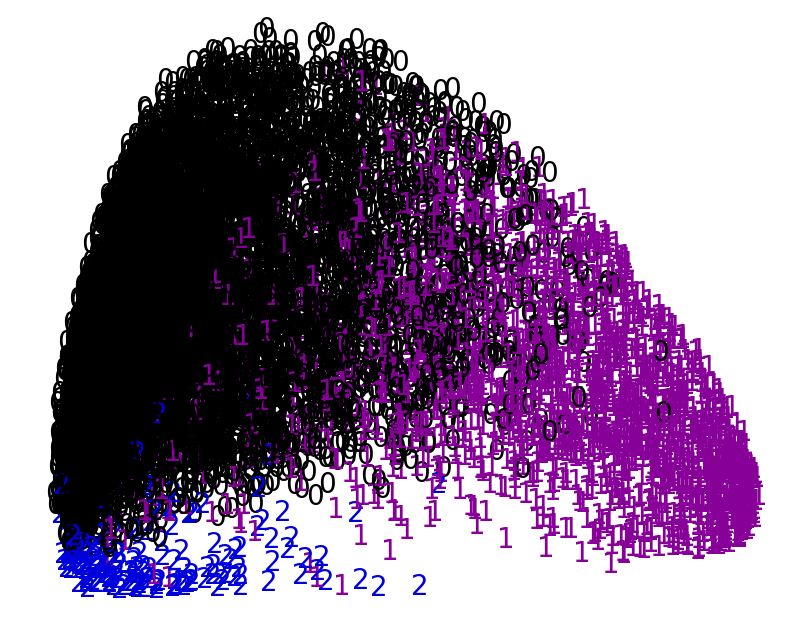

In [8]:
plt.clf()
plt.figure(figsize=(10, 8))

# plt.scatter(x, y, color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), s=1)
plt.scatter(x, y, color='w', s=1)


# plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.)

for i, sentence in enumerate(sentences):

    # plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color='black', fontsize=8)
    # plt.annotate('°', (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=20)

    plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=20)
    

if not os.path.exists(OUTPUT_PATH + str(n_clusters) + 'topics'): os.mkdir(OUTPUT_PATH + str(n_clusters) + 'topics')

plt.axis("off")
# plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-'+str(MODEL).replace('/','').replace('.','') + '.eps', bbox_inches='tight', format='eps')
plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-'+str(MODEL).replace('/','').replace('.','') + '.png', bbox_inches='tight', transparent=True)

<Figure size 640x480 with 0 Axes>

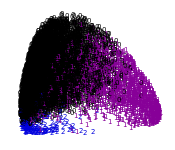

In [9]:
plt.clf()
plt.figure(figsize=(2, 1.7))

plt.scatter(x, y, color='w', s=1)

for i, sentence in enumerate(sentences):
    # plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color='gray', fontsize=18)
    plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=5)

plt.axis("off")
plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-mini-'+str(MODEL).replace('/','').replace('.','')+ '.png', bbox_inches='tight', transparent=True)



## Topic Hierarchy

<Figure size 640x480 with 0 Axes>

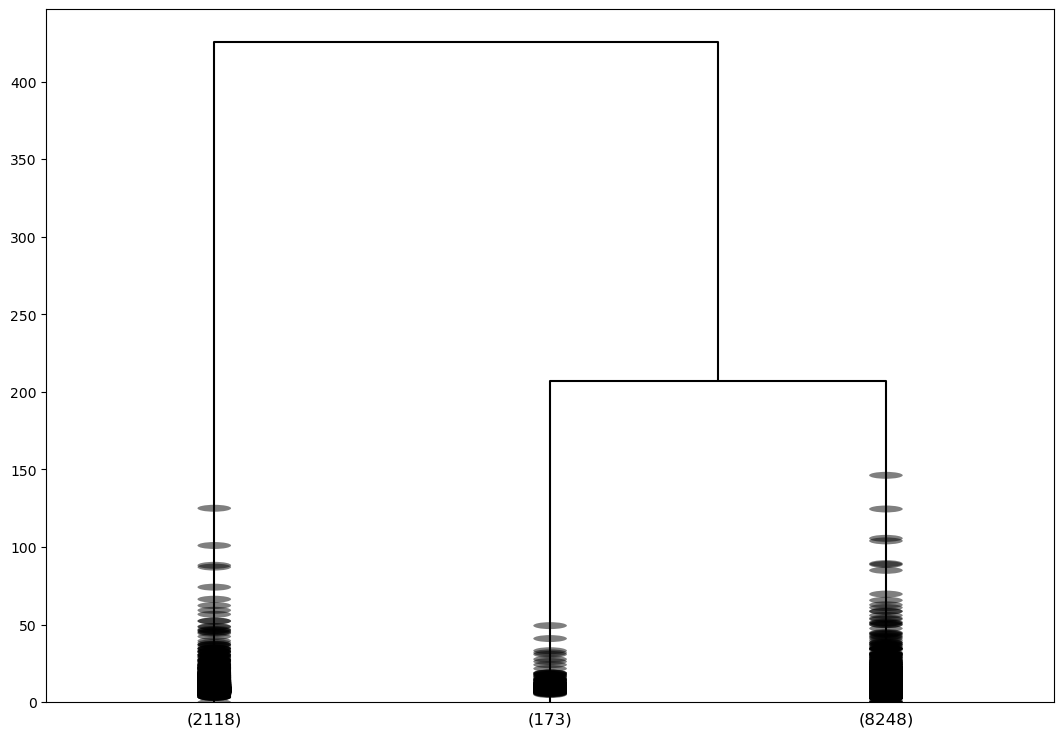

In [10]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np

plt.clf()
plt.figure(figsize=(13,9))

counts = np.zeros(clustering_model.children_.shape[0])
n_samples = len(clustering_model.labels_)

for i, merge in enumerate(clustering_model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else: current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([clustering_model.children_, clustering_model.distances_, counts]).astype(float)

r = dendrogram(linkage_matrix, truncate_mode='lastp', p=n_clusters, color_threshold=0, show_contracted=True, above_threshold_color='black')
# r = dendrogram(linkage_matrix, truncate_mode=None, above_threshold_color='black', color_threshold=0, no_labels=True)
# plt.axhline(c='black', linestyle='--', y=DISTANCE_THRESHOLD) 

# plt.savefig(OUTPUT_PATH + 'dendrograma-'+str(MODEL).replace('/','').replace('.','')+'.eps', bbox_inches='tight')
plt.savefig(OUTPUT_PATH + 'dendrograma-'+str(MODEL).replace('/','').replace('.','')+'.png', bbox_inches='tight')


# Step 3: Representing Topics

In [11]:
MAX_DF = 0.99
TOP_WORDS = 10

In [12]:
class Topic:
    def __init__(self, cluster):
        self.cluster = cluster
        self.sentences = []
        self.sentences_dump = ""
        self.wordcloud = WordCloud()
        self.terms = []
        self.texts = []
        self.sorted_terms = []
        self.sorted_tfidfs = []
        self.coherence = 0.0

In [13]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

topics = [Topic(i) for i in range(n_clusters)]
# n_cases_by_cluster = [0 for i in range(n_clusters)]

for i in range(len(sentences)):
    cluster_index = clustering_model.labels_[i]
    topics[cluster_index].sentences.append(sentences[i])
    topics[cluster_index].sentences_dump += sentences[i] + " "
    # n_cases_by_cluster[cluster_index] += 1

tfidf_model = TfidfVectorizer(max_df=MAX_DF)
# tfidf_model = TfidfVectorizer(stop_words='english')

c_tfidf = tfidf_model.fit_transform([topic.sentences_dump for topic in topics])

terms = tfidf_model.get_feature_names_out()
terms_by_topic = tfidf_model.inverse_transform(c_tfidf)
tfidf_matrix = c_tfidf.toarray()

# print(len(terms))
# print(len(terms_by_topic))
# for i in terms_by_topic:
#     print(len(i))
    
    
for i, topic in enumerate(topics):
    sorted_term_indexes = np.argsort(tfidf_matrix[topic.cluster])

    sorted_terms, sorted_tfidfs = [], []
    for j in sorted_term_indexes:
        sorted_terms.append(terms[j])
        sorted_tfidfs.append(tfidf_matrix[topic.cluster][j])
       
    topic.sorted_terms = sorted_terms
    topic.sorted_tfidfs = sorted_tfidfs
    topic.terms = terms_by_topic[i]
    # topic.corpus = 
    
    dense = c_tfidf[topic.cluster].todense()
    lst1 = dense.tolist()
    tfidf_data_frame = pd.DataFrame(lst1, columns=terms)

    topic.wordcloud = WordCloud(mode='RGBA', background_color="white", max_words=TOP_WORDS, color_func=lambda *args, **kwargs: "black").generate_from_frequencies(tfidf_data_frame.T.sum(axis=1))

In [14]:
# len(terms_by_topic[2])

<Figure size 640x480 with 0 Axes>

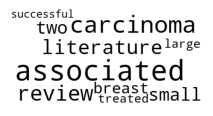

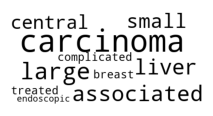

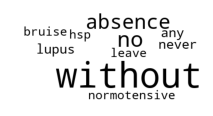

In [15]:
from matplotlib import pyplot as plt 

plt.clf()

for topic in topics:
    # plt.figure(figsize=(5, 4))
    plt.figure(figsize=(2.5, 2.5))

    plt.imshow(topic.wordcloud)
    plt.axis("off")
    # plt.show()

    if not os.path.exists(OUTPUT_PATH + str(n_clusters) + 'topics'): os.mkdir(OUTPUT_PATH + str(n_clusters) + 'topics')

    plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/wordcloud'+str(topic.cluster)+'.png', transparent=True, bbox_inches='tight')


In [16]:
# # topics[0].sorted_terms[:10]
# for t in topics:
#     print(t.sorted_terms[-10:])
#     print(t.sorted_tfidfs[-10:])
#     print('\n\n')

#     print(len(t.terms))
#     print(len(t.sorted_terms))
#     print(len(t.sorted_tfidfs))
#     print()


#     # sorted_terms[:10]

In [17]:
# print(tfidf_model.max_df * len(topics))
# print()
# print(tfidf_model.get_stop_words())
# c_tfidf

# Validação

In [18]:
TOP_WORDS = 10

In [19]:
# texts[1][12]
# # print(len(corpus))
# # len(dictionary)
# # type(dictionary)

# len(texts[1])

In [20]:
# t.dictionary = Dictionary(terms_by_topic)
# cprpus = ''
# for i, tt in enumerate(terms_by_topic):
#     corpus.append(dictionary.doc2bow(tt)) # in BoW format.

# # topic.corpus = corpus
#     # corpus = [dictionary.doc2bow(t) for t in terms_by_topic] # in BoW format.

# for c in corpus:
#     # print(c)
#     texts.append(dictionary[word_id] for word_id, freq in c) # (list of list of str, optional) –  texts Tokenized in bow format

# # corpus = [dictionary.doc2bow(t) for t in terms_by_topic] # in BoW format.



In [21]:
# print(cm)

In [22]:
# # for t in topics:
# #     cm = CoherenceModel(topics=t.sorted_terms, texts=texts, corpus=corpus, dictionary=t.dictionary, coherence='c_v',topn=TOP_WORDS)

# cm = CoherenceModel(topics=[topic.sorted_terms for topic in topics], texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)
# # cm = CoherenceModel(topics=top_terms_by_topic, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)

# total_coherence = cm.get_coherence()
# coherence_per_topic = cm.get_coherence_per_topic()

# for i, coherence in enumerate(coherence_per_topic):
#     topics[i].coherence = coherence

# print('Total Coherence: ', total_coherence)
# print('Coherence by Topic: ', coherence_per_topic)    

In [ ]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

dictionary = Dictionary(terms_by_topic)
corpus = [dictionary.doc2bow(t) for t in terms_by_topic] # in BoW format.
texts = [[dictionary[word_id] for word_id, freq in c] for c in corpus] # (list of list of str, optional) –  texts Tokenized in bow format

# cm = CoherenceModel(topics=[topic.sorted_terms for topic in topics], texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)
cm = CoherenceModel(topics=[topic.terms for topic in topics], texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)

# cm = CoherenceModel(topics=top_terms_by_topic, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)

total_coherence = cm.get_coherence()
coherence_per_topic = cm.get_coherence_per_topic()

for i, coherence in enumerate(coherence_per_topic):
    topics[i].coherence = coherence

print('Total Coherence: ', total_coherence)
print('Coherence by Topic: ', coherence_per_topic)    

In [24]:
with open(OUTPUT_PATH + '/[minimal]topic-attention-results.txt', "a") as file:
    print('Hyper-parameters: ', file=file) 
    print('Language Model: ' + MODEL + '\t Distance Threshold: '+str(DISTANCE_THRESHOLD) + '\t Resulting Topics: '+str(n_clusters) + '\t TfIdf Threshold: '+str(MAX_DF) + '\t Top Words: '+str(TOP_WORDS), file=file)   
    print("", file=file)
    for topic in topics:
        print('Topic '+str(topic.cluster), file=file)    
        print('Documents length: '+str(len(topic.sentences)), file=file)
        print('Terms length: '+str(len(topic.terms)), file=file)

        print('Coherence: '+str(topic.coherence), file=file)
        print('Top Words: '+str(topic.sorted_terms[-10:]), file=file)  
        print('', file=file)

    print('Total Coherence: '+str(total_coherence), file=file)  
    print('Total Terms considered: '+str(len(topic.sorted_tfidfs)), file=file)
    print('----------------------------------------------------------------------------', file=file)  

# -----------------------------

In [25]:
### corrigir ordem dos termos. Ja esta corrigido no notebook oficial e no artigo
print('Topics in ascending sort of coherence.')
sorted_topic_indexes = np.argsort(coherence_per_topic)
for i,j in enumerate(sorted_topic_indexes):    
    print(i, topics[j].coherence, topics[j].sorted_terms[:10])

Topics in ascending sort of coherence.
0 0.34608088564858125 ['000', 'neuropathological', 'neurophaty', 'neurophysiological', 'neuroprotection', 'neuropsychological', 'neuroradiography', 'neuronopathy', 'neuroradiological', 'neuroretinitis']
1 0.6975314466788982 ['gagging', 'average', 'jugulare', 'judkin', 'rebleeding', 'submarine', 'pico', 'submitral', 'mesentery', 'cholecystogastric']
2 0.9959332041316198 ['000', 'pash', 'passenger', 'passive', 'passport', 'past', 'pasteurella', 'pasteurianus', 'patau', 'pasadenensis']


<Figure size 640x480 with 0 Axes>

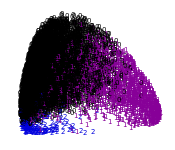

In [26]:
plt.clf()
plt.figure(figsize=(2, 1.7))

plt.scatter(x, y, color='w', s=1)

for i, sentence in enumerate(sentences):
    # plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color='gray', fontsize=18)
    plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=5)

plt.axis("off")
plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-mini-'+str(MODEL).replace('/','').replace('.','')+ '.png', bbox_inches='tight', transparent=True)